In [4]:
%load_ext autoreload
%load_ext autotime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime


In [5]:
%autoreload 2

In [6]:
import sys
sys.path.append('../../../')

# Controles Sintéticos utilizando GAMs
Modelos Aditivos Generalizados para el diseño de contrafactuales robustos.

[<img src="assets/gamsc/gamsc-qr.png" width="600" style="display: block; margin-left: auto; margin-right: auto;"/>](assets/gamsc/i-quit.png "The worst")

## Un poco sobre mí

- Andrés Bucchi, VP de Data & Analytics @ Sodimac; previamente Uber HQ.
- Sodimac tiene presencia en 7 países; Data & Analytics cerca de 100 personas
- Tenemos múltiples proyectos interesantes, desde plataformas de Data hasta Analítica Avanzada, pero lo que más nos (me) gusta es la experimentación.
- Soy de profesión Ingeniero Comercial (BBA), pero mi pasión siempre fue el programar.

## Un poco sobre los Controles Sintéticos

Los controles sintéticos nos permiten realizar análisis causal cuando no existen otras alternativas (más robustas) para construir un contrafactual válido — e.g., muestreo aleatorio, muestreo temporal, cuasi-experimentos, etc.

Este tipo de análisis es de altísima utilidad al momento de evaluar el efecto de distintas políticas de intervención que no pueden "prenderse y apagarse" o no pueden ofrecérseles solamente a un grupo de individuos. Por ejemplo -

- Un sistema de atención de urgencia que podría salvar más vidas, lo que presenta un problema ético y reputacional.
- Mejores condiciones en créditos hipotecarios según un nuevo modelo de riesgo, si es que la ley no permite tener ofertas diferentes para un mismo producto, bajo mismas condiciones.
- Apertura de una nueva tienda y posible efecto en canales online.
- Entre __muchos__ otros...

## Un poco sobre GAMs

Generalized Additive Models (GAMs) son el resultado de una combinación lineal de Generalizaed Linear Models (GMLs). Permiten relacionar la __media__ de una serie de respuesta $Y$ a un vector de controles $X$, a través de una función de vínculo $g(·)$.

$$
g(E[y]) = f_0(x_0) + f_1(x_1) + ... + f_k(x_k)
$$

La función $g(·)$ puede tomar múltiples formas, y puede ser interpretada como la función inversa a la media de alguna familia de distribuciones — e.g., en el caso de una poisson, si la media $\mu$ puede ser expresada como una combinación lineal de $X$

$$
\mu=e^{X\beta}
$$

Entonces $g(·)$ es la función exponencial y $g^{-1}(·)$ es $ln(\mu)$.

### ¿Y qué?

El principal take-away es que los GAMs son muy flexibles y, en general, permiten construir forecasts con errores iid. que se comportan de una forma normalizada, agregando distintos niveles de tendencias y quiebres de tendencias, etc. Esto las convierte en muy buenas candidatas para el análisis contrafactual.

## Construyendo un contrafactual

Buscamos construir un contrafactual $\hat{y}_c$ con la finalidad de estimar el efecto $\delta{y}$ de un tratamiento, dado que

$$
\hat{ \delta{y} } = y - \hat{y}_c
$$

Nótese que $y$ es un valor conocido y observado tanto antes como después del tratamiento.

Utilizando GAMs, podemos reescribir lo anterior -

$$
\hat{ \delta{y} } = y - g^{-1}(f_0(x_0) + f_1(x_1) + ... + f_k(x_k))
$$

Donde $X$ representa un vector de controles, utilizado para construir nuestro contrafactual $\hat{y}_c$.

### Eligiendo los controles correctos

Al construir $\hat{y}_c$, lo que queremos evitar es la interferencia, ya que no debiesen existir cualquier tipo de contaminación desde los controles hacia la respuesta y viceversa. Visualmente,

[<img src="assets/gamsc/good.png" width="600" style="display: block; margin-left: auto; margin-right: auto;"/>](assets/gamsc/good.png "The good")

Y lo que debemos evitar -

[<img src="assets/gamsc/bad.png" width="600" style="display: block; margin-left: auto; margin-right: auto;"/>](assets/gamsc/bad.png "The bad")

[<img src="assets/gamsc/also-bad.png" width="600" style="display: block; margin-left: auto; margin-right: auto;"/>](assets/gamsc/also-bad.png "The worse")

[<img src="assets/gamsc/i-quit.png" width="600" style="display: block; margin-left: auto; margin-right: auto;"/>](assets/gamsc/i-quit.png "The worst")

### Por ejemplo

Utilizar los volúmenes de abastecimiento para construir un contrafactual de ventas es...

- __Incorrecto__ — un mayor volumen de ventas incrementará la cantidad de pedidos de abastecimiento, por lo que la respuesta y el control tienen una relación causal. Utilizar el abastecimiento interno como control va a generar un feedback positivo -

        mayores ventas observadas
            >> mayores órdenes de abastecimiento
                >> predicción de un contrafactual más alto
                    >> subestimación del efecto del tratamiento

Utiliza la venta de otras tiendas para construir un contrafactual de ventas en una tienda distinta es...

- __Correcto__ — podemos asumir razonablemente que las ventas están principalmente afectadas por factores exógenos o causas comunes, independientes a un tratamiento, por lo que representan una buena alternativa para construir un contrafactual robusto.

## Otros beneficios de los GAMs

Los GAMs están ampliamente cubiertas por distintos paquetes en Python, varios de ellos bastante sofisticados y con una gran comunidad de soporte opensource. Mejor todavía - Facebook tiene un motor de forecasting llamado `Prophet` que permite, entre otras cosas, realizar muestreo posterior, ¡lo que facilita muchísimo la construcción de intervalos de confianza!

```bash
$ pip install prophet
```

[Documentación](https://facebook.github.io/prophet/).

## ¡Manos a la obra!

Empecemos por importar `fbprophet`. También utilizaremos algunas funcionalidades de `SodiMX`, el paquete de Experimentación de Sodimac — no es opensource todavía.

In [8]:
import numpy as np
import pandas as pd
try:
    import fbprophet
except ImportError:
    import prophet as fbprophet
try:
    from sodimx.synthetic_control.utils import SyntheticData
except ImportError:
    from utils import SyntheticData
from matplotlib import pyplot as plt

plt.style.use('ggplot')

%matplotlib inline

Necesitamos un poco de data sintética, para la cuál, por diseño, además sabremos el efecto real.

In [9]:
sd = SyntheticData(
    impulse=0.03,
    noise=10.0,
    bias=0.1,
    n_controls=20,
    n_informative_controls=10,
    n_samples=150,
    n_treatment=30
)
X, Y, slices = sd.make_arma()

$X$ es una matriz de series de tiempos de distintos controles, pero de los cuales solamente algunos son informativos, mientras otros tienen como objetivo el agregar ruido y probar la robustez de nuestro método.

In [11]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2021-05-30,-8.544111,15.648429,-7.121805,16.443887,4.601226,-0.108324,-6.341720,-7.470710,-28.587414,6.006472,7.569650,3.316353,3.721769,15.509269,-0.201731,1.348539,8.967389,13.881873,-2.938492,3.378491
2021-05-31,-7.447693,1.904122,-11.376288,16.621413,-0.279264,9.856329,-12.465589,34.238972,28.427218,6.417384,7.122696,5.095405,-5.559460,8.098105,34.830585,-0.116241,14.729300,-1.286926,-0.755297,0.636300
2021-06-01,-1.469995,1.750055,-10.020635,16.269278,2.658967,6.491619,-14.727704,4.143352,-6.004030,10.686000,5.237442,10.902914,-1.668595,16.479214,26.716832,0.911240,14.443813,23.113580,-3.792967,4.608560
2021-06-02,7.099451,-17.733669,-14.181534,17.412150,12.358673,8.569656,-14.651859,6.710788,33.175375,9.167945,14.449084,-5.994485,0.338628,7.971604,21.937071,2.616061,11.467972,-4.584749,-7.731492,7.555510
2021-06-03,-18.229799,18.968659,-8.903114,17.797786,8.675661,-1.248070,-9.706767,27.720573,2.765875,5.773219,8.050140,2.438925,4.497304,9.541865,29.845215,-0.329158,10.219502,7.205322,-6.023020,-4.991733


$Y$ contiene la serie de tiempo de respuesta. Prophet requiere que existan las columnas `ds` e `y`, con las fechas de la serie y el valor de la respuesta, respectivamenente.

In [13]:
Y.rename(columns={0: 'y'}, inplace=True)
Y['ds'] = Y.index
Y.head()

,y,ds
2021-05-30,86.526903,2021-05-30
2021-05-31,184.610222,2021-05-31
2021-06-01,140.184854,2021-06-01
2021-06-02,142.052834,2021-06-02
2021-06-03,169.726846,2021-06-03


El objeto `slices` contiene los períodos de tratamiento y blackout. En este caso no vamos a utilizar períodos de blackout — podríamos querer eliminar días de lluvia, cybers, etc. — pero Prophet permite imputar automáticamente data faltante, por lo que es perfectamente válido remover (algunos) outliers.

In [15]:
treatment_ixs = Y.loc[slices['treatment']].index
control_ixs = Y.index.difference(treatment_ixs)
slices

{'treatment': slice(Timestamp('2021-09-27 00:00:00', freq='D'), Timestamp('2021-10-26 00:00:00', freq='D'), None),
 'blackouts': []}

Visualmente, las series no muestran un claro quiebre en la respuesta $Y$ durante el período de control y tratamiento.

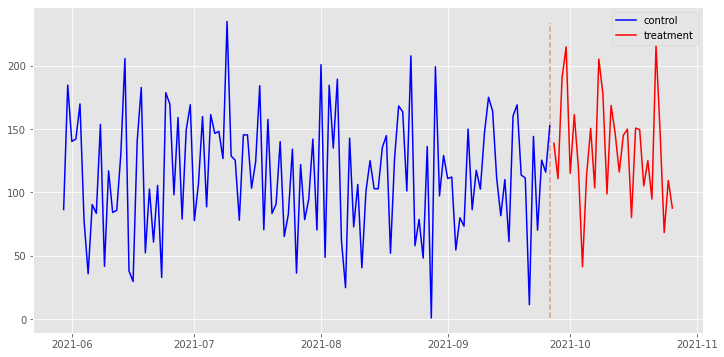

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Y.loc[control_ixs, 'y'], color='blue', label='control')
ax.plot(Y.loc[treatment_ixs, 'y'], color='red', label='treatment')
ax.vlines(x=control_ixs[-1],ymin=ax.dataLim.bounds[1],ymax=ax.dataLim.bounds[3],linestyle='--',alpha=0.5)
ax.legend();

### Utilizando Prophet

Veamos si logramos encontrar algún tipo de tendencia a través de `fbprophet`. Por ahora, solamente vamos a estar utilizando la serie de tiempo $Y$, apoyándonos en las capacidades de análisis de series de tiempo que `fbprophet` provee.

Para datasets pequelos, el proceso es relativamente rápido. Hasta ahora, solamente estaremos aprendiendo los parámetros más probables para nuestras GAMs. Más adelante utilizaremos muestreo sobre los posteriores, tanto para hacer forecasting como para construir intervalos de confianza.

In [18]:
mdl = fbprophet.Prophet()
mdl.fit(Y.loc[control_ixs, :]);

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.90885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       135.394   5.61758e-05       111.687   5.861e-07       0.001      148  LS failed, Hessian reset 
      99       135.397   2.94919e-06       100.314      0.5832      0.5832      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       135.398   4.14549e-09       99.3383      0.1798      0.1798      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Para construir forecasts necesitamos utilizar los métodos `make_future_dataframe` y `predict`.

In [20]:
mdl.make_future_dataframe(30)

,ds
0,2021-05-30
1,2021-05-31
2,2021-06-01
3,2021-06-02
4,2021-06-03
...,...
145,2021-10-22
146,2021-10-23
147,2021-10-24
148,2021-10-25


In [22]:
_ = mdl.make_future_dataframe(30)
forecast = mdl.predict(_)
forecast.index = pd.DatetimeIndex(forecast['ds'], name='')
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
,,,,,,,,,,,,,,,,
2021-05-30,2021-05-30,113.921951,61.973351,182.415839,113.921951,113.921951,10.781218,10.781218,10.781218,10.781218,10.781218,10.781218,0.0,0.0,0.0,124.703169
2021-05-31,2021-05-31,113.923837,57.464957,167.844966,113.923837,113.923837,2.947621,2.947621,2.947621,2.947621,2.947621,2.947621,0.0,0.0,0.0,116.871458
2021-06-01,2021-06-01,113.925722,50.944249,171.164566,113.925722,113.925722,-2.571083,-2.571083,-2.571083,-2.571083,-2.571083,-2.571083,0.0,0.0,0.0,111.354640
2021-06-02,2021-06-02,113.927608,37.294295,159.956290,113.927608,113.927608,-15.325158,-15.325158,-15.325158,-15.325158,-15.325158,-15.325158,0.0,0.0,0.0,98.602450
2021-06-03,2021-06-03,113.929494,59.738695,173.691226,113.929494,113.929494,1.796573,1.796573,1.796573,1.796573,1.796573,1.796573,0.0,0.0,0.0,115.726067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,2021-10-22,114.176515,67.647147,184.692848,114.176038,114.176988,13.897931,13.897931,13.897931,13.897931,13.897931,13.897931,0.0,0.0,0.0,128.074446
2021-10-23,2021-10-23,114.178204,49.251863,165.466036,114.177703,114.178702,-11.527102,-11.527102,-11.527102,-11.527102,-11.527102,-11.527102,0.0,0.0,0.0,102.651102
2021-10-24,2021-10-24,114.179894,69.110921,183.317108,114.179360,114.180405,10.781218,10.781218,10.781218,10.781218,10.781218,10.781218,0.0,0.0,0.0,124.961112


Los forecasts no son muy buenos. Definitivamente algo falta.

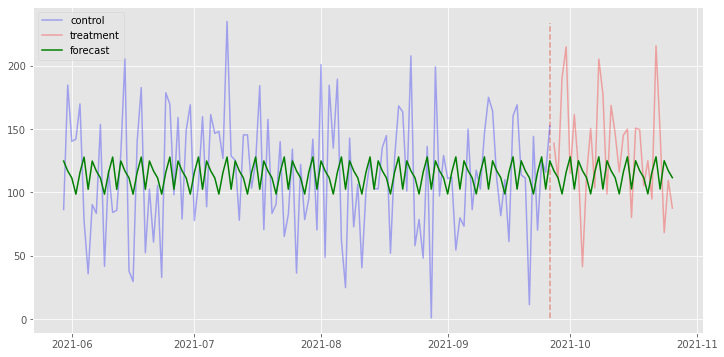

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Y.loc[control_ixs, 'y'], color='blue', label='control', alpha=0.3)
ax.plot(Y.loc[treatment_ixs, 'y'], color='red', label='treatment', alpha=0.3)
ax.vlines(x=control_ixs[-1], ymin=ax.dataLim.bounds[1], ymax=ax.dataLim.bounds[3], linestyle='--', alpha=0.5)
ax.plot(forecast.yhat, color='green', label='forecast')
ax.legend();

### Agreguemos controles

¡Los controles son informativos! Si los agregamos, vamos a mejorar nuestra capacidad de capturar efectos exógenos, que solamente agregan variabilidad no capturada a nuestra serie $Y$.

Entrenemos un segundo modelo, esta vez incluyendo todos los controles como regresores adicionales. Necesitaremos utilizar el método `add_regressor`, además de entregar los valores para cada uno de estos controles al momento de generar forecasts con `predict`.

In [24]:
X.rename(columns={
    c: 'x{}'.format(c) for c in X.columns
}, inplace=True)
X.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
2021-05-30,-8.544111,15.648429,-7.121805,16.443887,4.601226,-0.108324,-6.341720,-7.470710,-28.587414,6.006472,7.569650,3.316353,3.721769,15.509269,-0.201731,1.348539,8.967389,13.881873,-2.938492,3.378491
2021-05-31,-7.447693,1.904122,-11.376288,16.621413,-0.279264,9.856329,-12.465589,34.238972,28.427218,6.417384,7.122696,5.095405,-5.559460,8.098105,34.830585,-0.116241,14.729300,-1.286926,-0.755297,0.636300
2021-06-01,-1.469995,1.750055,-10.020635,16.269278,2.658967,6.491619,-14.727704,4.143352,-6.004030,10.686000,5.237442,10.902914,-1.668595,16.479214,26.716832,0.911240,14.443813,23.113580,-3.792967,4.608560
2021-06-02,7.099451,-17.733669,-14.181534,17.412150,12.358673,8.569656,-14.651859,6.710788,33.175375,9.167945,14.449084,-5.994485,0.338628,7.971604,21.937071,2.616061,11.467972,-4.584749,-7.731492,7.555510
2021-06-03,-18.229799,18.968659,-8.903114,17.797786,8.675661,-1.248070,-9.706767,27.720573,2.765875,5.773219,8.050140,2.438925,4.497304,9.541865,29.845215,-0.329158,10.219502,7.205322,-6.023020,-4.991733


In [26]:
mdl2 = fbprophet.Prophet()
[
    mdl2.add_regressor(name=c) for c in X.columns
];

Para hacer las cosas más sencillas, creemos un único dataframe que contenga tanto la serie de respuesta como los controles, además de la columna `ds`, requerida por Prophet.

In [28]:
XY = pd.concat([X, Y], axis=1, ignore_index=False)
XY.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x12,x13,x14,x15,x16,x17,x18,x19,y,ds
2021-05-30,-8.544111,15.648429,-7.121805,16.443887,4.601226,-0.108324,-6.341720,-7.470710,-28.587414,6.006472,...,3.721769,15.509269,-0.201731,1.348539,8.967389,13.881873,-2.938492,3.378491,86.526903,2021-05-30
2021-05-31,-7.447693,1.904122,-11.376288,16.621413,-0.279264,9.856329,-12.465589,34.238972,28.427218,6.417384,...,-5.559460,8.098105,34.830585,-0.116241,14.729300,-1.286926,-0.755297,0.636300,184.610222,2021-05-31
2021-06-01,-1.469995,1.750055,-10.020635,16.269278,2.658967,6.491619,-14.727704,4.143352,-6.004030,10.686000,...,-1.668595,16.479214,26.716832,0.911240,14.443813,23.113580,-3.792967,4.608560,140.184854,2021-06-01
2021-06-02,7.099451,-17.733669,-14.181534,17.412150,12.358673,8.569656,-14.651859,6.710788,33.175375,9.167945,...,0.338628,7.971604,21.937071,2.616061,11.467972,-4.584749,-7.731492,7.555510,142.052834,2021-06-02
2021-06-03,-18.229799,18.968659,-8.903114,17.797786,8.675661,-1.248070,-9.706767,27.720573,2.765875,5.773219,...,4.497304,9.541865,29.845215,-0.329158,10.219502,7.205322,-6.023020,-4.991733,169.726846,2021-06-03


Entrenemos el nuevo modelo.

In [29]:
mdl2.fit(XY.loc[control_ixs, :]);

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.90885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       744.466    0.00115268       2033.64           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       756.032    0.00549589       3700.11           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       768.691   3.15865e-05       561.601      0.9835      0.9835      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        780.47   0.000579492        697.11           1           1      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       788.157   0.000358259       1552.16           1           1      543   
    Iter      log prob        ||dx||      ||grad||       alpha  

    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6199       974.477   2.47094e-06       963.741      0.4709           1     6607   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6299       975.029   3.09087e-05       2927.15      0.3727           1     6716   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6399       975.687     5.907e-05       2075.43           1           1     6829   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6499       976.041   2.66749e-05       1160.59           1           1     6936   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6599       976.235   5.62654e-06       604.321      0.9098      0.9098     7044   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    6699     

Para hacer un forecast, ahora tenemos pasar tanto los valores de los controles como la columna `ds`, en el mismo dataframe.

In [31]:
Xt = mdl2.make_future_dataframe(30)
Xt.index = pd.DatetimeIndex(Xt.ds, name='')
Xt = pd.concat([Xt, X], axis=1)
Xt.tail()

,ds,x0,x1,x2,x3,x4,x5,x6,x7,x8,...,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19
2021-10-22,2021-10-22,5.208456,24.708358,-16.340409,15.963733,5.752419,-2.180218,-6.169670,54.903735,20.311163,...,4.900545,-0.883910,8.320927,8.564678,33.575752,0.582756,14.717001,-0.075824,-1.657352,-4.681852
2021-10-23,2021-10-23,-12.747502,1.448790,-0.697755,16.174671,7.716568,1.790248,-9.661526,30.899505,0.860831,...,7.209571,0.070292,0.786285,14.810534,-12.323639,1.409756,14.550701,19.215859,-4.567178,8.201097
2021-10-24,2021-10-24,-0.132520,5.227963,-20.932831,17.050036,10.988485,-8.877332,-10.631184,-39.581552,40.232254,...,24.458870,5.450814,1.304998,11.406690,-18.480848,0.925458,9.493565,-4.157747,-7.089378,1.300972
2021-10-25,2021-10-25,5.113860,-3.557947,-13.690444,16.100994,7.983171,-11.071727,-15.402876,11.250265,42.170635,...,13.066098,1.655978,8.397756,11.213803,-23.053918,1.134690,13.539531,-7.336001,0.666257,4.250038
2021-10-26,2021-10-26,2.522906,-3.254646,-3.917761,17.918402,8.207552,-3.133699,-14.997805,-13.521384,-4.505437,...,13.166538,2.150638,3.596036,12.253693,6.921760,0.147852,10.980306,-4.532837,-1.496235,8.429366


In [32]:
forecast2 = mdl2.predict(Xt)
forecast2.index = pd.DatetimeIndex(forecast2.ds, name='')
forecast2

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,x8,x8_lower,x8_upper,x9,x9_lower,x9_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
,,,,,,,,,,,,,,,,,,,,,
2021-05-30,2021-05-30,113.545304,86.457813,86.585492,113.545304,113.545304,-27.021216,-27.021216,-27.021216,-27.021267,...,-47.173856,-47.173856,-47.173856,0.000389,0.000389,0.000389,0.0,0.0,0.0,86.524088
2021-05-31,2021-05-31,113.546532,184.545132,184.670167,113.546532,113.546532,71.061483,71.061483,71.061483,71.062699,...,9.841293,9.841293,9.841293,0.000337,0.000337,0.000337,0.0,0.0,0.0,184.608016
2021-06-01,2021-06-01,113.547761,140.114321,140.247230,113.547761,113.547761,26.636774,26.636774,26.636774,26.637117,...,-24.590268,-24.590268,-24.590268,-0.000197,-0.000197,-0.000197,0.0,0.0,0.0,140.184535
2021-06-02,2021-06-02,113.548989,141.986531,142.115108,113.548989,113.548989,28.502762,28.502762,28.502762,28.503312,...,14.589494,14.589494,14.589494,-0.000007,-0.000007,-0.000007,0.0,0.0,0.0,142.051751
2021-06-03,2021-06-03,113.550217,169.662724,169.790498,113.550217,113.550217,56.179145,56.179145,56.179145,56.179174,...,-15.820283,-15.820283,-15.820283,0.000418,0.000418,0.000418,0.0,0.0,0.0,169.729363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-22,2021-10-22,113.551015,208.979676,209.539242,113.259971,113.828623,95.714257,95.714257,95.714257,95.713261,...,1.725164,1.725164,1.725164,-0.000292,-0.000292,-0.000292,0.0,0.0,0.0,209.265273
2021-10-23,2021-10-23,113.551083,142.904579,143.508005,113.244276,113.841747,29.660012,29.660012,29.660012,29.658921,...,-17.725344,-17.725344,-17.725344,0.000684,0.000684,0.000684,0.0,0.0,0.0,143.211095
2021-10-24,2021-10-24,113.551151,65.991269,66.636592,113.231339,113.855053,-47.237043,-47.237043,-47.237043,-47.237093,...,21.646436,21.646436,21.646436,-0.000170,-0.000170,-0.000170,0.0,0.0,0.0,66.314109


In [34]:
forecast2.head().columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'extra_regressors_additive', 'extra_regressors_additive_lower',
       'extra_regressors_additive_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'x0', 'x0_lower', 'x0_upper', 'x1', 'x1_lower',
       'x1_upper', 'x10', 'x10_lower', 'x10_upper', 'x11', 'x11_lower',
       'x11_upper', 'x12', 'x12_lower', 'x12_upper', 'x13', 'x13_lower',
       'x13_upper', 'x14', 'x14_lower', 'x14_upper', 'x15', 'x15_lower',
       'x15_upper', 'x16', 'x16_lower', 'x16_upper', 'x17', 'x17_lower',
       'x17_upper', 'x18', 'x18_lower', 'x18_upper', 'x19', 'x19_lower',
       'x19_upper', 'x2', 'x2_lower', 'x2_upper', 'x3', 'x3_lower', 'x3_upper',
       'x4', 'x4_lower', 'x4_upper', 'x5', 'x5_lower', 'x5_upper', 'x6',
       'x6_lower', 'x6_upper', 'x7', 'x7_lower', 'x7_upper', 'x8', 'x8_lower',
       'x8_upper', 'x9', 'x9_lower', 'x9_

¡Los resultados son mucho mejores!

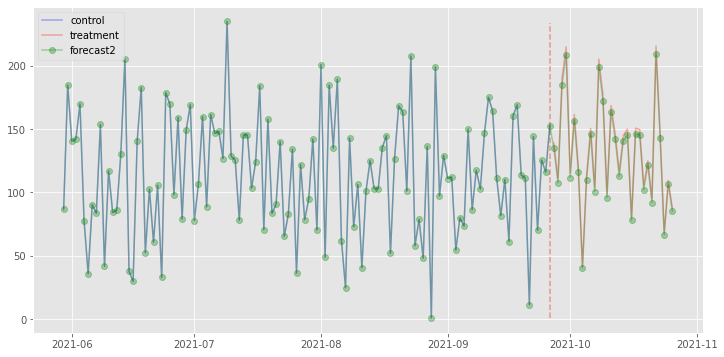

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(Y.loc[control_ixs, 'y'], color='blue', label='control', alpha=0.3)
ax.plot(Y.loc[treatment_ixs, 'y'], color='red', label='treatment', alpha=0.3)
ax.vlines(x=control_ixs[-1], ymin=ax.dataLim.bounds[1], ymax=ax.dataLim.bounds[3], linestyle='--', alpha=0.5)
ax.plot(forecast2.yhat, color='green', label='forecast2', alpha=0.3, marker='o')
ax.legend();

## Estimemos el efecto

Lo que nos interesa hacer es estimar el efecto e impulso total y lo las diferencias diarias, aunque podríamos medir diferencias significativas a nivel diario también. Para esto, necestiamos asegurar que estamos haciendo muestro posterior sobre series __acumuladas__ y no valores diarios.

Formalmente, el efecto total sería -

$$
\sum_{i\in{\ T}}{\delta{y}_i} = \sum_{i\in{\ T}}{(y_i - \hat{y}_i)}
$$

con $T$ representando el período de tratamiento.

### Acceso a muestreo posterior

Prophet entrega un fácil acceso a sampleo posterior del modelo, una vez entrenado. Podemos utilizar estas muestras no solamente para estimar el efecto punto a nivel diario, sino que también simular los intervalos de confianza. ¡Excelente!

In [36]:
Yhat = mdl2.predictive_samples(Xt.loc[treatment_ixs, :])['yhat']
print(Y.loc[treatment_ixs, 'y'].shape, Yhat.shape)
Yhat

(30,) (30, 1000)


array([[134.74454636, 134.84745895, 134.81493148, ..., 134.81199209,
        134.72712762, 134.73515679],
       [107.50821869, 107.55800184, 107.61407659, ..., 107.5348206 ,
        107.5211517 , 107.54054063],
       [184.8337984 , 184.77911781, 184.82257848, ..., 184.80048729,
        184.70346527, 184.84208668],
       ...,
       [ 66.34752581,  66.2313105 ,  66.03079428, ...,  66.02540267,
         66.24046681,  65.87494065],
       [106.18925383, 106.12984248, 105.83542875, ..., 105.96426709,
        106.29169952, 105.82807268],
       [ 84.99435543,  85.04052911,  84.68459661, ...,  84.74621928,
         84.95971864,  84.61283446]])

134.78862632074188

Podemos utilizar estas muestras para construir series de diferencias diarias entre observado $y_t$ y contrafactual $\hat{y}_t$, lo que nos permitirá calcular diferentes estadísticas sobre las series cumulativas.

In [41]:
# observed response
yt = Y.loc[treatment_ixs, ['y']].values
print(yt.shape)
yt[:10]

(30, 1)


array([[138.8341233 ],
       [110.78515639],
       [190.35384887],
       [214.76337156],
       [114.98945743],
       [161.32816227],
       [119.25036169],
       [ 41.48538939],
       [113.38538017],
       [150.48962715]])

El contrafactual está marginalmente bajo el observado. Ya sabemos que esto es correcto, dado que conocemos el impulso real.

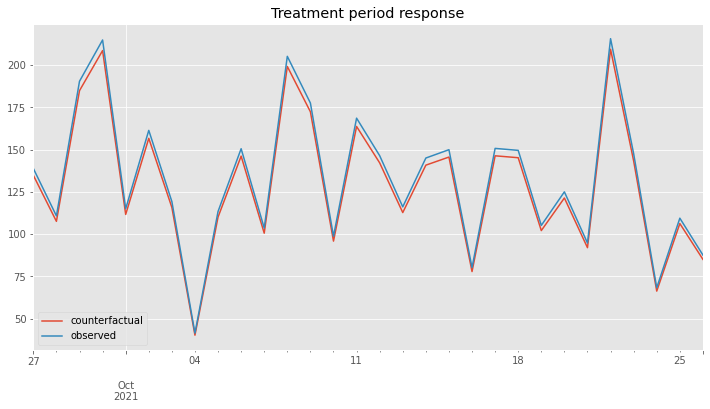

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_title('Treatment period response')
pd.Series(Yhat.mean(axis=1), index=treatment_ixs).plot(label='counterfactual')
pd.Series(yt.flatten(), index=treatment_ixs).plot(ax=ax, label='observed')
ax.legend();

### Pero, ¿podremos detectar esto de forma estadísticamente significativa?

### ¡Sí!

In [71]:
cdY = np.subtract(yt, Yhat).cumsum(axis=0)
# impulse
effect = pd.DataFrame(
    cdY.mean(axis=1)/Yhat.mean(axis=1).cumsum(),
    index=treatment_ixs,
    columns=['impulse_point']
)
l, u = np.percentile(cdY, [2.5, 97.5], axis=1)
effect['impulse_lb'] = l/Yhat.mean(axis=1).cumsum()
effect['impulse_ub'] = u/Yhat.mean(axis=1).cumsum()
effect = effect[['impulse_lb', 'impulse_point', 'impulse_ub']]

# total effect
effect['total_point'] = cdY.mean(axis=1)
effect['total_lb'] = l
effect['total_ub'] = u

print('Ground truth: {}'.format(sd.impulse))
pd.DataFrame([effect.iloc[-1][:3].to_dict()])

Ground truth: 0.03


,impulse_lb,impulse_point,impulse_ub
0,0.028192,0.029952,0.031612


array([107.32145969, 116.3831143 , 124.8398293 ])

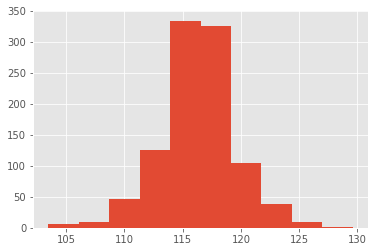

In [68]:
plt.hist(cdY[29]);
np.percentile(cdY[29], [1, 50, 99])

También podemos construir unos buenos gráficos para presentar los resultados de nuestra política de intervención, asegurando el "efecto wow".

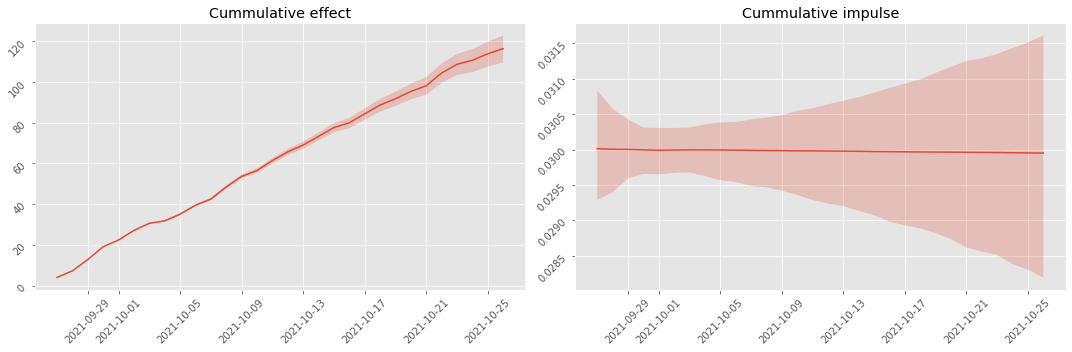

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Cummulative effect')
axs[0].plot(effect.total_point)
axs[0].fill_between(x=effect.index, y1=effect.total_lb, y2=effect.total_ub, alpha=0.25)
axs[0].tick_params(rotation=45)
axs[1].set_title('Cummulative impulse')
axs[1].plot(effect.impulse_point)
axs[1].fill_between(x=effect.index, y1=effect.impulse_lb, y2=effect.impulse_ub, alpha=0.25)
axs[1].tick_params(rotation=45)

fig.tight_layout()

# Algunas ideas para cerrar

- Los Controles Sintéticos nos permiten realizar análisis causal sobre procesos en los que no podemos implementar experimentos válidos, incluso no aleatorios.
- Utilizar controles es una gran forma de reducir el ruido en nuestras series, aislando mejor los efectos causales de un tratamiento, y mejorando nuestras estimaciones de los efectos.
- Los GAMs son un gran candidato para construir contrafactuales robustos, ya que son muy flexibles y tienen bastante soporte en Python — e.g., Facebook Prophet.
- El proceso, por lo general, es muy bajo en consumo computacional, por lo que es recomendable realizar análisis de sensibilidad sobre los resultados — agregar o quitar días, mover el período de intervención un día hacia adelante y atrás, agregar y sacar controles, etc.

# ¡Gracias!
- ¿Preguntas?
- Pueden descargar el código [aquí](https://github.com/misterte/talks).